# A joint multilevel model for CAR 
## With Cross Validation
Using MVS.CARLeroux
## Common Markov Gaussian Random Field
 $$ [P , S ] = [P | GMRF_p] [ S | GMRF_s] $$

In [25]:
## Import code:
setwd('/apps/external_plugins/biospytial_rwrapper/biospytial.rwrapper/R/')
rm(list=ls())                                                                                     
source("init_data.R")
library(pROC)
library('caret')

In [26]:
## Extract the response variables
Y = TDF %>% select(Pinophyta,Plantae)
## Extract the formula
formula_presence
rhs <- ~ Elevationm + MeanTempm
X <- model.frame(rhs,DataFrame,na.action='na.pass')

species ~ Elevationm + MeanTempm

In [27]:
colnames(DataFrame)

[1] "X"               "LUCA"            "Plantae"         "Pinophyta"      
 [5] "Abies"           "cellids"         "Disttoroadm"     "Elevationm"     
 [9] "MaxTempm"        "MeanTempm"       "MinTempm"        "Populationm"    
[13] "Precipitationm"  "SolarRadiationm" "VaporPresm"      "WindSpm"        
[17] "Longitude"       "Latitude"        "wwfmhtnum"       "wwfmhtnam"      
[21] "covid"           "name"            "covid2"          "tipos"          
[25] "geometry"        "sample"          "species"

In [28]:
K = dim(M_bis)[1]
trials <- matrix(rep(1.0,K*2), ncol=2)

In [ ]:
## This is wrong, the formula is also wrong!
## Make ROC curve


#burnin = 500
#n.sample = 1000
#thin = 1


n.sample = 10000
burnin=5000                                                                                                                                                           
thin = 5


#trains = createFolds(y = DataFrame$species, k=7, returnTrain = TRUE)
validate = createFolds(y = DataFrame$species, k=7, returnTrain = FALSE)

DataFrame$presences <- DataFrame$species
l <- list()
i = 1
DataFrame$predicted_values_CV <- NA
for (fold in validate) {
    model3 = list()
    observed.presences <- DataFrame$species[fold]
    ## Substitue by NA
    DataFrame$species[fold] <- NA
    
    
    
    model3 <- MVS.CARleroux(cbind(species,sample) ~ Elevationm + MeanTempm, 
                        family = 'binomial',
                        trials=trials,
                        W=M_bis,
                        rho = 1,
                        burnin = burnin,
                        n.sample = n.sample,
                        thin = thin,
                        data = DataFrame
                         )
    

    DataFrame$species <- DataFrame$presences
    ## Return original values
    DataFrame$predicted_values_CV[fold] <- model3$fitted.values[fold]
    predicted.probability <- model3$fitted.values[fold]
    pROC_obj <- roc(observed.presences,predicted.probability)

    l[[i]] <- pROC_obj
    i = i + 1
}


Setting up the model.
Generating 1000 post burnin and thinned (if requested) samples.
  |=============================================================         |  87%

In [ ]:
pROC_obj <- roc(DataFrame$species,DataFrame$predicted_values_CV,
               smoothed= TRUE,
               ci = TRUE, ci.alpha=0.9, stratified=FALSE,
               plot=TRUE, auc.polygon=TRUE, max.auc.polygon=TRUE, grid=TRUE,
               print.auc=TRUE, show.thres=TRUE)
sens.ci <- ci.se(pROC_obj)
plot(sens.ci,type="shape",col="lightblue")
plot(sens.ci, type="bars")



In [ ]:
model3$modelfit

In [57]:
#burnin = 500
#n.sample = 1000
#thin = 1

burnin = 50000
n.sample = 100000
thin = 50

model3 <- MVS.CARleroux(cbind(species,sample) ~ Elevationm + MeanTempm, 
                        family = 'binomial',
                        trials=trials,
                        W=M_bis,
                        rho = 1,
                        burnin = burnin,
                        n.sample = n.sample,
                        data = DataFrame
                         )

In [36]:
## model
model3$modelfit

DIC           p.d          WAIC           p.w          LMPL 
    3331.1252      797.2520     3416.3121      697.0430    -1785.8440 
loglikelihood 
    -868.3106

In [37]:
model3$summary.results

,Median,2.5%,97.5%,n.sample,% accept,n.effective,Geweke.diag
species - (Intercept),-5.6195,-6.5047,-4.5228,1000,56.1,19.8,6.9
species - Elevationm,0.0002,-0.0002,0.0006,1000,56.1,24.1,-1.9
species - MeanTempm,-0.0006,-0.0010,-0.0001,1000,56.1,35.9,1.1
sample - (Intercept),2.0737,1.5336,2.7480,1000,56.1,27.2,4.4
sample - Elevationm,0.0000,-0.0002,0.0001,1000,56.1,126.6,0.4
sample - MeanTempm,0.0005,0.0001,0.0008,1000,56.1,16.4,-4.9
Sigma11,18.8216,12.4095,22.9481,1000,100.0,8.5,-4.0
Sigma22,5.7928,4.5191,7.4953,1000,100.0,7.3,0.1
rho,1.0000,1.0000,1.0000,NA,NA,NA,NA


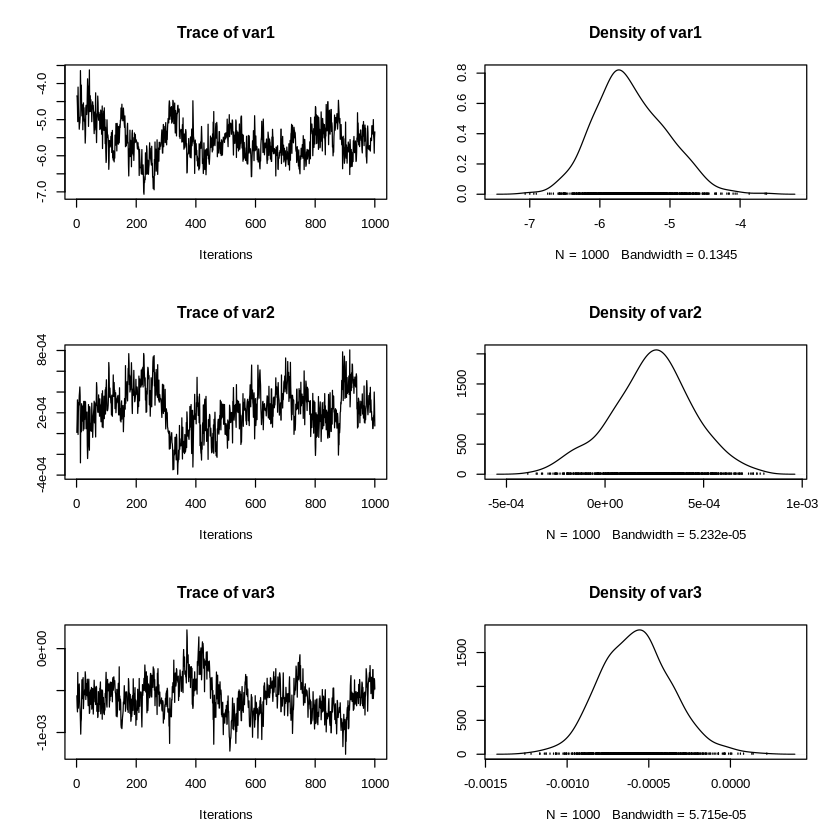

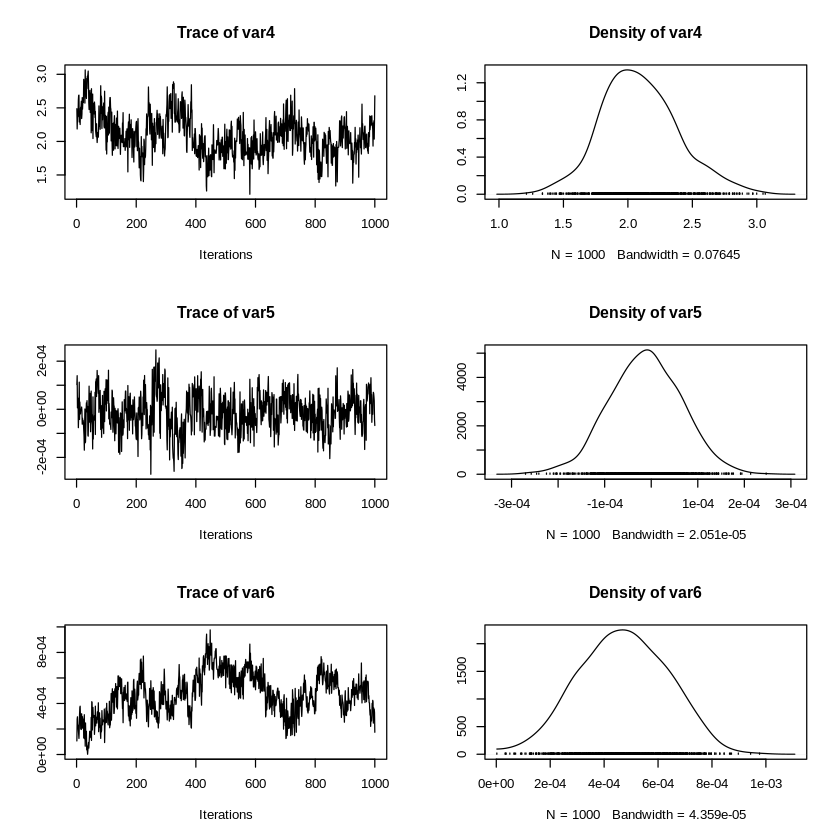

In [38]:
plot(model3$samples$beta)

## Generate datasets. several columns for summary stats

In [39]:
getUpperLowerCI <- function(fitted_sample,prefix="",MARGIN=1){
    fp = partial(quantile,probs=c(0.025,0.5,0.975))
    quants =apply(X = fitted_sample,FUN = fp,MARGIN)
    mfitt = apply(fitted_sample,mean,MARGIN = MARGIN)
    vfitt = apply(fitted_sample,var,MARGIN = MARGIN)
    new_data = cbind(t(quants),mfitt,vfitt)
    l = as.list(c("q025","median","q0975","mean","variance"))
    nnames = lapply(l,function (x){return(paste(prefix,x,sep = '_'))})
    colnames(new_data) = nnames
    return(new_data)
}

In [40]:
nK <- dim(TDF)[1]
sample_fitted <- data.frame(t(model3$samples$fitted))
sample_phi <- data.frame(t(model3$samples$phi))

In [41]:
impar = seq(from=1,to=dim(sample_fitted)[1],by=2)
par = seq(from=2,to=dim(sample_fitted)[1],by=2)

In [49]:
sPS = sP * sS

[1] 4060 1000

In [51]:
sS = sample_fitted[par,]
sP = sample_fitted[impar,]

S <- getUpperLowerCI(sS,prefix = 'S')
P <- getUpperLowerCI(sP,prefix = 'P')
PS <- getUpperLowerCI(sPS,prefix='PS')

In [43]:
sPhiS <- sample_phi[par,]
sPhiP <- sample_phi[impar,]
PhiS <- getUpperLowerCI(sPhiS,prefix='PhiS')
PhiP <- getUpperLowerCI(sPhiP,prefix='PhiP')

## Sample the posterior

In [53]:
post.sample_p = data.frame(model3$samples$fitted)
pss  <- post.sample_p %>% mutate_all(function(p) rbernoulli(1,p))
## divide samples for S and P according to the order given up
pred.S <- pss[,par]
pred.P <- pss[,impar ]
sumps <- colSums(pred.S)
sumpp <- colSums(pred.P)
nsample <- nrow(pred.S)

                                     
ProbS <- sumps / nsample
#nsample <- nrow(pred.P)
ProbP <- sumpp / nsample
ProbPS <- ProbS * ProbP
samples <- cbind(ProbP,ProbS,ProbPS)

ERROR: Error in cbind(PX, PY, PXY): object 'PX' not found


## Save to posterity

In [55]:
data <- cbind(TDF$cellids,PhiP,PhiS,P ,S,PS,ProbP,ProbS,ProbPS,samples)

In [56]:
file_ = '/outputs/presence_only_models/modelCAR3-v2.csv'
write.csv(data,file_)

## Save fitted samples (P,S)

In [106]:
sample_fitted <- t(model3$samples$fitted)
fitted_chain <- cbind(TDF$cellids,sample_fitted)
file2 <- '/outputs/presence_only_models/modelCAR_model3_fitted_sample.csv'
write.csv(fitted_chain,file2)

In [107]:
sample_phi <- t(model3$samples$phi)
nK <- dim(TDF)[1]

S <- sample_phi[1:nK,]
P <- sample_phi[(nK +1) : (2*nK), ]
chain = cbind(TDF$cellids,S)
file_ = '/outputs/presence_only_models/modelCAR_model3_phi_S.csv'
write.csv(chain,file_)
chain = cbind(TDF$cellids,P)
file_ = '/outputs/presence_only_models/modelCAR_model3_phi_P.csv'
write.csv(chain,file_)


 num [1:4060] 5.30e-05 1.89e-05 2.16e-07 2.14e-06 2.15e-06 ...


In [27]:
## P and S
## divide samples for S and P according to the order given up
nK <- dim(TDF)[1]
fittedv = model3$fitted.values
S <- fittedv[1:nK]
P <- fittedv[(nK +1) : (2*nK) ]
chain = cbind(TDF$cellids,S,P)
#file_ = '/outputs/presence_only_models/modelCAR_model3_fitted.csv'
#write.csv(chain,file_)


In [32]:
dim(model3$fitted.values)

[1] 4060    2

In [37]:
dPhi = data.frame(model3$samples$phi)

In [39]:
S <- dPhi[,1:nK]
P <- dPhi[,(nK +1) : (2*nK)]

In [56]:
mms = apply(dPhi,MARGIN=2,FUN = mean)

In [61]:
head(mms)

X1         X2         X3         X4         X5         X6 
-10.021744 -11.631782  -9.174576 -10.509941  -8.804521 -10.059669

In [57]:
ms = matrix(mms,nrow=nK,ncol=2,byrow = T)

In [62]:
head(ms)

-10.021744,-11.631782
-9.174576,-10.509941
-8.804521,-10.059669
-8.893093,-10.184749
-8.723113,-10.049559
-8.437156,-9.878672


In [58]:
fitted_chain <- cbind(TDF$cellids,ms)
file2 <- '/outputs/presence_only_models/modelCAR_model3_test.csv'
write.csv(fitted_chain,file2)


In [110]:
str(model3$samples$Sigma)

 num [1:50000, 1:2, 1:2] 60 60.8 58.7 61.4 57.5 ...


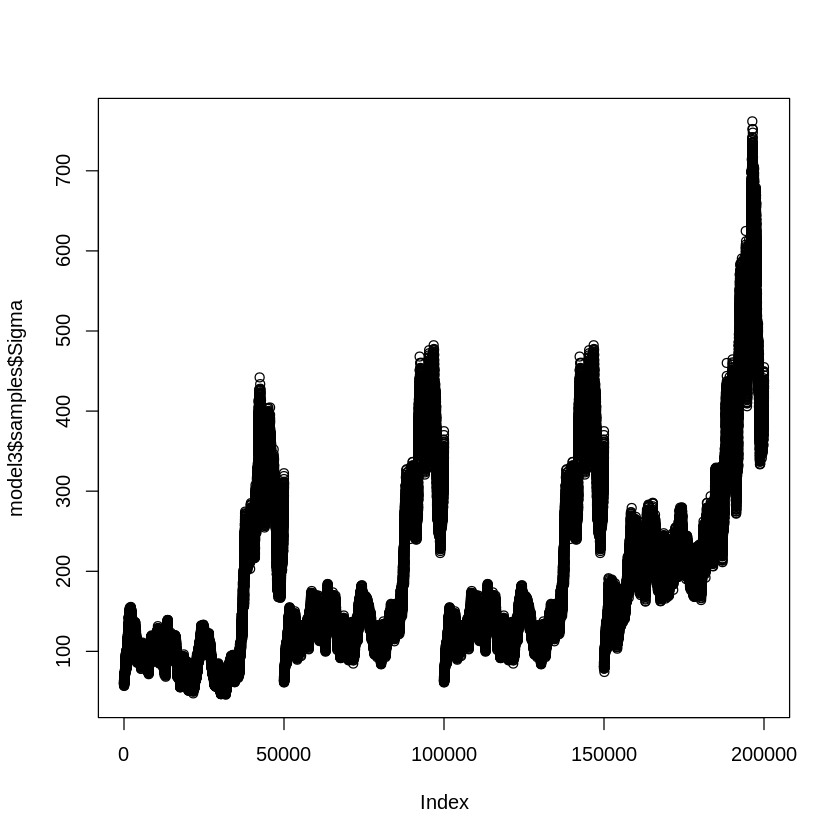

In [111]:
plot(model3$samples$Sigma)